In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import shutil
import seaborn as sns
import vcf
#from cyvcf2 import VCF

sns.set_style('whitegrid')
sns.set_palette('colorblind')
from collections import Counter

In [2]:
def parse_vcf_snpeff_record(record, sample):
    parsed_records = []
    
    for ix, alt in enumerate(record.ALT):
        parsed_alt = {}

        # get var only for that alt
        var_list = [ann for ann in record.INFO['ANN'] if ann.split('|')[0] == alt]
        #remove up/downstream/intergenic mutations
        var_list = [ann for ann in var_list if ann.split('|')[1] not in ['upstream_gene_variant', 
                                                                                 'downstream_gene_variant']]
        if len(var_list) > 1:
            print("var_list has multiple changes", var_list)
            assert False
        elif len(var_list) == 0:
            print("var_list has no annotation", var_list)
            assert False
        else:
            ann = var_list[0].split('|')
            parsed_alt['Mutation Effect'] = ann[1]
            parsed_alt['Mutation Gene'] = ann[3]
            parsed_alt['Nucleotide Mutation'] = ann[9]
        
            if ann[1] == 'intergenic_region':
                parsed_alt['Protein Mutation'] = f"No Protein Effect ({ann[9]})"
            elif ann[1] == 'synonymous_variant':
                parsed_alt['Protein Mutation'] = ann[3] + ": synonymous " + ann[10]
            else:
                parsed_alt['Protein Mutation'] = ann[3] + ":" + ann[10]

        parsed_alt['Sample'] = sample
        parsed_alt['Genome Position'] = record.POS
        
        
        parsed_alt['Allele Read Count'] = record.genotype(sample)['ALT_DP']
        parsed_alt['% Reads Supporting Allele'] = record.genotype(sample)['ALT_FREQ'] * 100
        parsed_alt['Total Read Count'] = record.INFO['DP']
    
    parsed_records.append(parsed_alt)
    return parsed_records

In [3]:
parsed_records = []
for snpeff_vcf in Path('snpeff_vcfs').glob("*.vcf"):
    with open(snpeff_vcf) as fh:
        reader = vcf.Reader(fh)
        sample = reader.samples[0]
        for record in reader:
            parsed_records.extend(parse_vcf_snpeff_record(record, sample))
variants = pd.DataFrame(parsed_records).sort_values(['Sample', 'Genome Position'])

In [4]:
variants.sort_values('Genome Position')

,Mutation Effect,Mutation Gene,Nucleotide Mutation,Protein Mutation,Sample,Genome Position,Allele Read Count,% Reads Supporting Allele,Total Read Count
89,intergenic_region,CHR_START-ORF1a,n.13T>C,No Protein Effect (n.13T>C),4658_P0,13,74,87.0588,85
188,intergenic_region,CHR_START-ORF1a,n.241C>T,No Protein Effect (n.241C>T),4581_OG,241,1117,99.8213,1119
355,intergenic_region,CHR_START-ORF1a,n.241C>T,No Protein Effect (n.241C>T),4645_P0,241,3472,100.0000,3472
0,intergenic_region,CHR_START-ORF1a,n.241C>T,No Protein Effect (n.241C>T),4649_OG,241,18,100.0000,18
437,intergenic_region,CHR_START-ORF1a,n.241C>T,No Protein Effect (n.241C>T),4581_P0,241,1782,100.0000,1782
...,...,...,...,...,...,...,...,...,...
88,missense_variant,ORF10,c.109C>T,ORF10:p.Leu37Phe,4649_OG,29666,1603,100.0000,1603
607,missense_variant,ORF10,c.109C>T,ORF10:p.Leu37Phe,4649_P0,29666,11232,99.9466,11238
521,missense_variant,ORF10,c.109C>T,ORF10:p.Leu37Phe,4581_P0,29666,7660,99.9869,7661
522,intergenic_region,ORF10-CHR_END,n.29754C>T,No Protein Effect (n.29754C>T),4581_P0,29754,4689,99.9787,4690


# Variant Changes Over Time

In [5]:
def plot_allele_pres_absence(variants_subset, title, savepath, all_mutations=False):

    coverage_thresold = 50
    
    variant_order = variants_subset.sort_values("Genome Position")['Protein Mutation'].unique()
    sample_order = variants_subset['Sample'].sort_values().unique()
    variant_presence_absence = pd.crosstab(variants_subset['Sample'], variants_subset['Protein Mutation'])
    variant_presence_absence = variant_presence_absence.loc[sample_order, variant_order].T

    variant_percentage_alleles = variants_subset[variants_subset['Protein Mutation'].isin(variant_presence_absence.index)]
    variant_percentage_alleles = variant_percentage_alleles.pivot('Sample', 'Protein Mutation', '% Reads Supporting Allele').fillna(0)
    variant_order = [x for x in variants_subset.sort_values('Genome Position')['Protein Mutation'].unique() if x in variant_percentage_alleles.columns]
    variant_percentage_alleles = variant_percentage_alleles.loc[sample_order, variant_order].T

    
    # drop any all >99% 
    if not all_mutations:
        all_high_coverage_variants = [var for var in variant_percentage_alleles.T if (variant_percentage_alleles.T[var] > 95).all() ]
        variant_percentage_alleles = variant_percentage_alleles.drop(all_high_coverage_variants)

    # low coverage mutations (possible dropout)
    low_coverage = variants_subset[variants_subset['Allele Read Count'] < coverage_thresold]['Protein Mutation'].unique()
                            
    #variant_percentage_alleles = variant_percentage_alleles.rename(index=possible_dropout)

    #return variant_percentage_alleles
    if len(variant_percentage_alleles) < 10:
        fig, ax = plt.subplots(figsize=(6,8))
    elif len(variant_percentage_alleles) > 30:
        fig, ax = plt.subplots(figsize=(6,16))
    else:
        fig, ax = plt.subplots(figsize=(6,12))


     
    #variant_percentage_alleles = variant_percentage_alleles[sorted(variant_percentage_alleles.columns, key=lambda x: x.split('-')[1])]
    
    ax.set_title(title)
    sns.heatmap(variant_percentage_alleles, vmin=0, vmax=100, linewidths=.1, ax=ax, xticklabels=True, cmap="mako_r", yticklabels=True,
                cbar_kws={'label': '% Reads Supporting Allele'})
    ax.set_ylabel(f"Protein Mutation\n(Any Sample <{coverage_thresold}X Coverage in Red)")
    ax.set_xlabel(f"Samples\n(Original Genomes in Bold)")

    # colour OG and low coverage labels
    for label in ax.get_yticklabels():
        if label.get_text() in low_coverage:
            label.set_color('red')
            
     # colour OG and low coverage labels
    for label in ax.get_xticklabels():
        if "OG" in label.get_text():
            label.set_fontweight('bold')
    #return label
    #return fig, ax
    plt.savefig(savepath, dpi=300, bbox_inches='tight', facecolor='white', transparent=False)

In [6]:
#variant_order = variants.sort_values("Genome Position")['Protein Mutation'].unique()
#variant_order

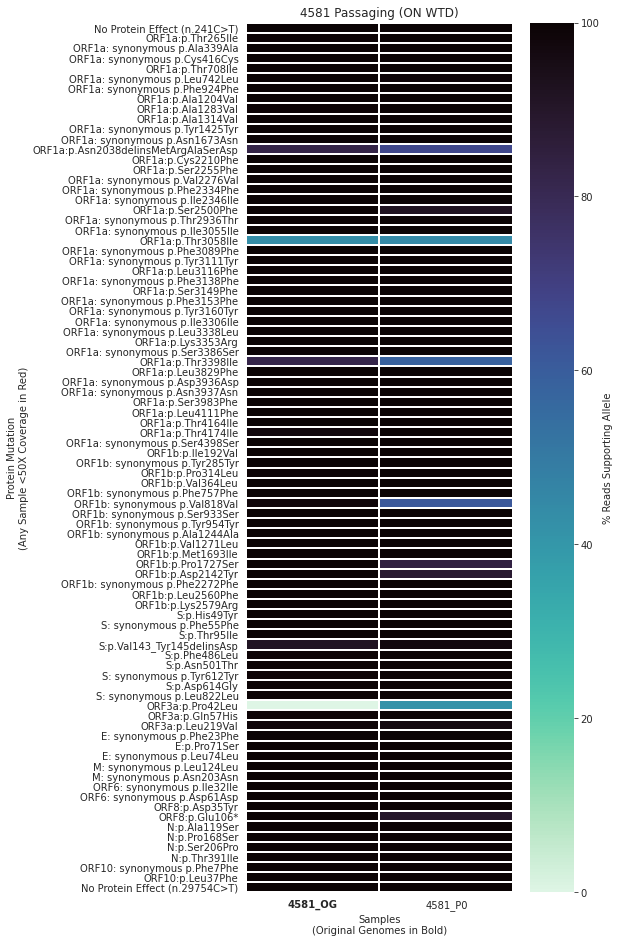

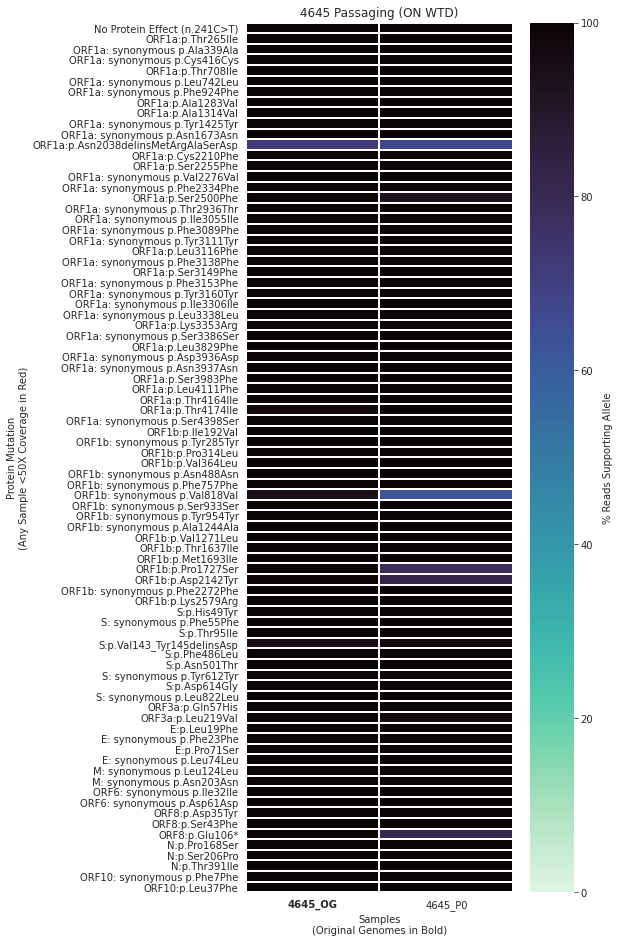

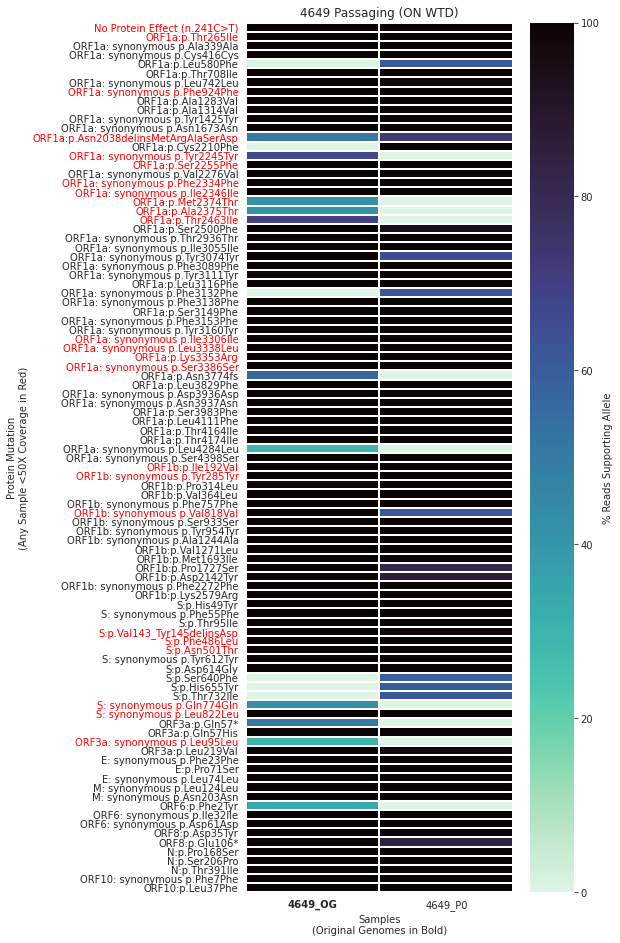

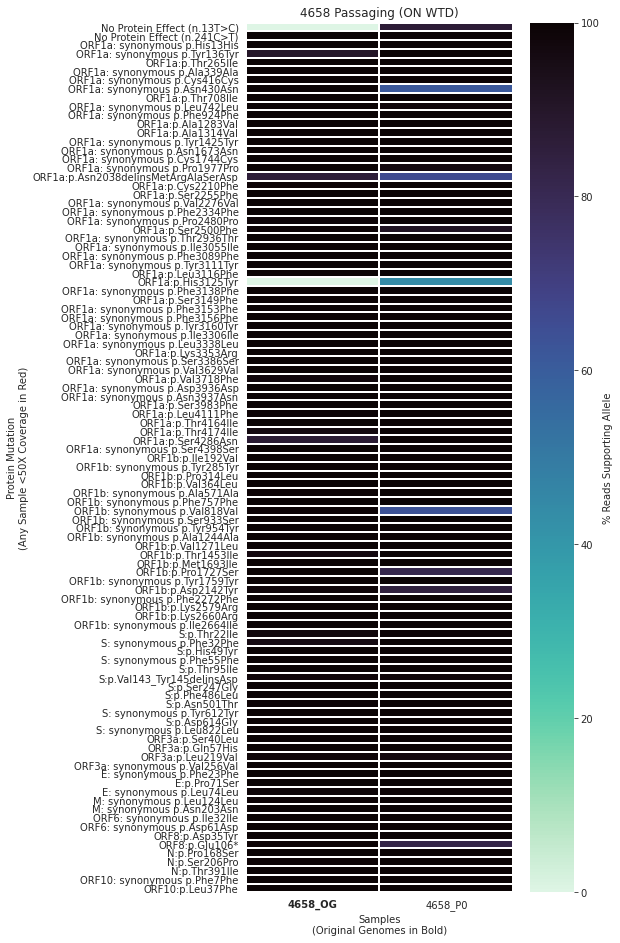

In [7]:
for sample in variants['Sample'].str.split('_').str.get(0).unique():
    sample_subset = variants[variants['Sample'].str.contains(sample)]
    
    plot_allele_pres_absence(sample_subset, f"{sample} Passaging (ON WTD)", f"{sample}_passaging_all.png", all_mutations=True)    
    plt.show()

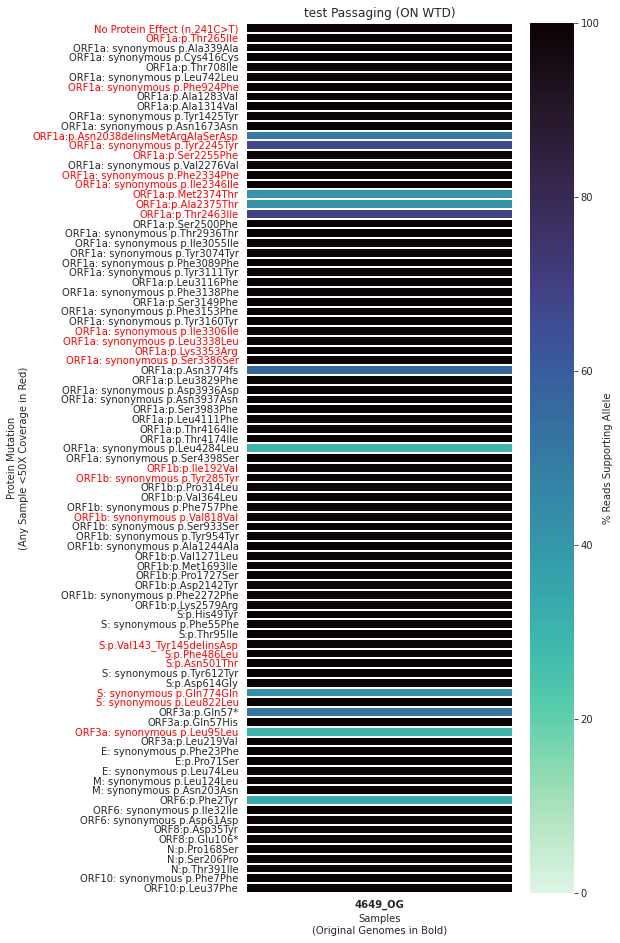

In [8]:
plot_allele_pres_absence(variants[variants['Sample'] == '4649_OG'], f"test Passaging (ON WTD)", f"test.png", all_mutations=True)    


In [9]:
with open('snpeff_vcfs/4649-OG.ann.vcf')

SyntaxError: invalid syntax (<ipython-input-9-c9c82d8a82a7>, line 1)

In [11]:
with open('snpeff_vcfs/4649-OG.ann.vcf') as fh:
    for record in vcf.Reader(fh):
        print(record.INFO)

{'DP': 18, 'ANN': ['T|upstream_gene_variant|MODIFIER|ORF1a|gene-ORF1a|transcript|TRANSCRIPT_gene-ORF1a|protein_coding||c.-25C>T|||||25|WARNING_TRANSCRIPT_NO_STOP_CODON', 'T|intergenic_region|MODIFIER|CHR_START-ORF1a|CHR_START-gene-ORF1a|intergenic_region|CHR_START-gene-ORF1a|||n.241C>T||||||']}
{'DP': 32, 'ANN': ['T|missense_variant|MODERATE|ORF1a|gene-ORF1a|transcript|TRANSCRIPT_gene-ORF1a|protein_coding|1/1|c.794C>T|p.Thr265Ile|794/13203|794/13203|265/4400||WARNING_TRANSCRIPT_NO_STOP_CODON']}
{'DP': 394, 'ANN': ['T|synonymous_variant|LOW|ORF1a|gene-ORF1a|transcript|TRANSCRIPT_gene-ORF1a|protein_coding|1/1|c.1017C>T|p.Ala339Ala|1017/13203|1017/13203|339/4400||WARNING_TRANSCRIPT_NO_STOP_CODON']}
{'DP': 410, 'ANN': ['T|synonymous_variant|LOW|ORF1a|gene-ORF1a|transcript|TRANSCRIPT_gene-ORF1a|protein_coding|1/1|c.1248C>T|p.Cys416Cys|1248/13203|1248/13203|416/4400||WARNING_TRANSCRIPT_NO_STOP_CODON']}
{'DP': 606, 'ANN': ['T|missense_variant|MODERATE|ORF1a|gene-ORF1a|transcript|TRANSCRIPT_ge